[Markdown cheatsheet](https://daringfireball.net/projects/markdown/syntax)

<h1>Analysis of Discourse Macrostructure in Schizophrenia: a Corpus Study</h1>
<b><i>Ryazanskaya Galina,
    Center for Language and Brain, HSE</i></b>

<h2>my plans</h2>

[my secrert plan for this project and more](https://docs.google.com/document/d/1GATeTSyHrhbg5M_5hWci77V3ys_P0gS8KzdyQY1JNLE/edit)

The corpus of Russian internet language I am using is called RuWac. Here I have a link: 
[RuWac about](https://bitbucket.org/kostialopuhin/russe)

I also provide a link for direct download of the corpus archive (9GB): 
[RuWac](http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz)

<h3>let us install everything</h3>

In [ ]:
!pip install numpy

In [ ]:
!pip install progressbar2

In [ ]:
!pip install gensim

__let us also download the archived corpus__

In [ ]:
!wget "http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz"

<h3>let us now do the things we will repeat many times as we work</h3>

In [ ]:
!git commit modeling_schizo.ipynb -m ""

In [105]:
import gensim
import logging
import lzma
import os
import random

import numpy as nx
import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime
from progressbar import progressbar
from string import punctuation as punct
from string import ascii_letters as latin
punct += '»«'

corpus_archive_filename = 'ruwac-parsed.out.xz'
corpus_filename = 'corpus.txt'
premodel_filename = 'small.model'
vocabulary_filename = 'freq.txt'
model_filename = 'full.model'
sample_directory = 'sample'

<h2>let us take the corpus out of the archive</h2>

__let us also take lemmas and make out of them a file with \n-separated sentences, including only sentences not containing latin symbols__

In [ ]:
with lzma.open(corpus_archive_filename, mode='rt', encoding='utf-8') as f:
    with open(corpus_filename, mode='w', encoding='utf-8') as t:
        current = []
        for line_number, line in enumerate(f):
            if line_number % 10000000 == 0:
                print(line_number, datetime.now().time(), file=open('archive_log.txt', 'a', encoding='utf-8'))
            l = line.split('\t')
            if len(l) == 7:
                lemm = l[3]
                sent = l[1]
                if sent == 'SENT':
                    if set(latin).intersection(set(''.join(current))) == set():
                        current.append('\n')
                        print(' '.join(current), file=t, end='')
                    current = []
                elif lemm not in punct:
                    current.append(lemm)

__here are some examples for me__

[word2vec source link](https://radimrehurek.com/gensim/models/word2vec.html)

[word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/)

[my previous work on w2v](https://github.com/flying-bear/HSE_programming/blob/master/HSE_programming_2/hws/hw_word2vec/HW_word2vec.ipynb)

<h2>let us create a subset of corpus for testing before training on the big corpus</h2>

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
sentences = []
with open(corpus_filename, 'r', encoding='utf-8') as file:
            for line in file:
                if len(sentences) < 1000:
                    sentences.append(line.split())
                else:
                    break

In [7]:
premodel = gensim.models.Word2Vec(sentences, min_count = 1, epochs=1)

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
2018-12-01 20:08:20,475 : INFO : collecting all words and their counts
2018-12-01 20:08:20,483 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-12-01 20:08:20,499 : INFO : collected 3542 word types from a corpus of 12137 raw words and 1000 sentences
2018-12-01 20:08:20,503 : INFO : Loading a fresh vocabulary
2018-12-01 20:08:20,539 : INFO : effective_min_count=1 retains 3542 unique words (100% of original 3542, drops 0)
2018-12-01 20:08:20,539 : INFO : effective_min_count=1 leaves 12137 word corpus (100% of original 12137, drops 0)
2018-12-01 20:08:20,591 : INFO : deleting the raw counts dictionary of 3542 items
2018-12-01 20:08:20,599 : INFO : sample=0.001 downsamples 43 most-comm

__let us check and save the test model__

In [17]:
premodel.wv['я']

array([ 0.00033608,  0.01961686, -0.0060016 ,  0.02352651,  0.0161804 ,
        0.00198638, -0.0156463 , -0.00617301, -0.0008622 ,  0.00333268,
       -0.01050657, -0.00588358, -0.00142256,  0.0070704 ,  0.0032397 ,
       -0.0143547 ,  0.00678462, -0.00413314,  0.00284421, -0.00290856,
        0.00344219, -0.01387355,  0.00470964, -0.01163711,  0.00467778,
       -0.00308427,  0.01401065, -0.00525512, -0.00533063, -0.00529045,
        0.00236804,  0.00438249,  0.00122866, -0.0019901 ,  0.01409124,
        0.00199817,  0.01031996,  0.00540237, -0.01548326, -0.00977472,
        0.00738592, -0.00249218,  0.00210615,  0.0234709 , -0.00541235,
        0.00151491,  0.00526316, -0.00303754, -0.0066194 , -0.0012779 ,
        0.00284218, -0.01179871, -0.0174361 ,  0.00898844,  0.00195034,
        0.01008916, -0.01302091, -0.00645701,  0.0221268 , -0.00095577,
       -0.01296543, -0.01397609, -0.00992239, -0.00804624, -0.00208522,
        0.00354438, -0.0281995 ,  0.01097893, -0.00234392, -0.00

In [13]:
list(premodel.wv.vocab.items())[:10]

[('это', <gensim.models.keyedvectors.Vocab at 0xf4627b5358>),
 ('тип', <gensim.models.keyedvectors.Vocab at 0xf4627b53c8>),
 ('девушка', <gensim.models.keyedvectors.Vocab at 0xf4627b5588>),
 ('в', <gensim.models.keyedvectors.Vocab at 0xf4627b55c0>),
 ('один', <gensim.models.keyedvectors.Vocab at 0xf4627b56a0>),
 ('день', <gensim.models.keyedvectors.Vocab at 0xf4627b56d8>),
 ('отмечать', <gensim.models.keyedvectors.Vocab at 0xf4627b5710>),
 ('что', <gensim.models.keyedvectors.Vocab at 0xf4627b5748>),
 ('на', <gensim.models.keyedvectors.Vocab at 0xf4627b5780>),
 ('себя', <gensim.models.keyedvectors.Vocab at 0xf4627b57b8>)]

In [5]:
premodel.similarity('найти', 'второй')

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.036809895

In [9]:
premodel.most_similar(positive=['банк'], negative=[], topn=10)

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('тотальнее', 0.35982415080070496),
 ('управляемый', 0.3162972331047058),
 ('решить', 0.3074740767478943),
 ('живой', 0.29716986417770386),
 ('баррикада', 0.29420873522758484),
 ('владелец', 0.29158836603164673),
 ('верить', 0.29105377197265625),
 ('маскировка', 0.29051047563552856),
 ('разгар', 0.28887930512428284),
 ('возможно', 0.28510481119155884)]

__let us save it__

In [11]:
premodel.save(premodel_filename)

2018-12-01 20:11:08,616 : INFO : saving Word2Vec object under word2vec.model, separately None
2018-12-01 20:11:08,632 : INFO : not storing attribute vectors_norm
2018-12-01 20:11:08,640 : INFO : not storing attribute cum_table
2018-12-01 20:11:08,824 : INFO : saved word2vec.model


__now we can load it__

In [5]:
premodel = gensim.models.Word2Vec.load(premodel_filename)

2018-12-10 22:16:39,757 : INFO : loading Word2Vec object from small.model
2018-12-10 22:16:39,884 : INFO : loading wv recursively from small.model.wv.* with mmap=None
2018-12-10 22:16:39,894 : INFO : setting ignored attribute vectors_norm to None
2018-12-10 22:16:39,903 : INFO : loading vocabulary recursively from small.model.vocabulary.* with mmap=None
2018-12-10 22:16:39,909 : INFO : loading trainables recursively from small.model.trainables.* with mmap=None
2018-12-10 22:16:39,915 : INFO : setting ignored attribute cum_table to None
2018-12-10 22:16:39,920 : INFO : loaded small.model


<h2>let us run the training on the full corpust text now</h2>

<h3>let us generate a vocabulary</h3>

In [2]:
def get_vocabulary(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            for word in line.split():
                yield word

In [22]:
def get_sentences(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            yield line.split()

In [11]:
word_freq = Counter(progressbar(get_vocabulary(corpus_filename)))

| |                    #                     | 1296566294 Elapsed Time: 0:48:07


__let us save it__

In [15]:
with open(vocabulary_filename, 'w', encoding='utf-8') as file:
    file.writelines(word_freq)

__now we can just read the vocabulary__

In [ ]:
with open(vocabulary_filename, 'r', encoding='utf-8') as file:
    word_freq = file.readlines()

<h3>let us give the model the vocabulary</h3>

In [17]:
model = gensim.models.Word2Vec(sg=1, min_count=10, workers=1, size=300)

In [18]:
logging.basicConfig(filename='vocabulary.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
model.build_vocab_from_freq(word_freq)

__let us save it__

In [20]:
model.save(model_filename)

<h3>let us train the model</h3>

In [26]:
logging.basicConfig(filename='training.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [27]:
model.train(get_sentences(corpus_filename), epochs=1, total_examples=len(word_freq))

(1100046103, 1296566295)

__let us save it__

In [29]:
model.save(model_filename)

In [31]:
model.most_similar(positive=['банк'], negative=[], topn=10)

/home/gryazanskaya/modeling_schizo/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/home/gryazanskaya/modeling_schizo/env/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('сбербанк', 0.8356039524078369),
 ('банковский', 0.8246872425079346),
 ('кредитный', 0.8222591876983643),
 ('ипотечный', 0.8164801597595215),
 ('банка', 0.804668664932251),
 ('втб', 0.7961848974227905),
 ('сберегательный', 0.7937512397766113),
 ('цб', 0.790773332118988),
 ('кредит', 0.7881439924240112),
 ('эмитент', 0.7846423387527466)]

__now we can load it__

In [2]:
model = gensim.models.Word2Vec.load(model_filename)

<h2>let us prepare the texts from the sample</h2>

__the sample consists of__ 

+ 9 outpatients diagnosed with schizophrenia
+ 10 controls from Russian Clinical Pear Stories Corpus (CliPS)

the original CliPS corpus contains pear film [Chafe, Freedle, & Bois, 1980](http://www.lattice.cnrs.fr/IMG/pdf/DuBois_1980_Beyond_Definiteness_L.pdf) retellings from people with aphasia, traumatic brain injuries, as well as healthy controls

the files contain already lemmatized texts with \n separated sentences (discourse units)

In [125]:
sample = {'control': {}, 'schizo': {}}

for filename in os.listdir(sample_directory):
    file_path = sample_directory + '/' + filename
    name = filename.strip('.txt')
    with open(file_path, 'r', encoding='utf-8') as file:
        raw_sent = file.readlines()
    sent = []
    for raw in raw_sent:
        sent.append(raw.strip().split())
    if 'H' in filename:
        sample['control'][name] = sent
    elif 'S' in filename:
        sample['schizo'][name] = sent

let us ensure that it works

In [23]:
sample['control']['HP-03']

[['вот', 'нет', 'текст'],
 ['это', 'так', 'задумать', 'да'],
 ['ну', 'я', 'думать', 'что', 'это', 'такой', 'такой', 'сюжетик', 'фильм'],
 ['значит',
  'это',
  'где-то',
  'южный',
  'страна',
  'может',
  'Мексика',
  'может',
  'что'],
 ['человек', 'там'],
 ['дело',
  'в',
  'то',
  'что',
  'это',
  'не',
  'на',
  'свой',
  'участок',
  'видно',
  'человек',
  'собирать',
  'урожай',
  'груша'],
 ['большой',
  'груша',
  'стоять',
  'дикий',
  'ну',
  'большой',
  'такой',
  'полноценный',
  'груша',
  'не',
  'дичка',
  'какой-то',
  'там',
  'вот'],
 ['и', 'в', 'общем', 'должен', 'быть', 'три', 'корзина', 'нагрузить', 'вот'],
 ['ну',
  'в',
  'один',
  'момент',
  'он',
  'значит',
  'сделать',
  'с',
  'один',
  'груша',
  'видно',
  'как',
  'благодарность',
  'этот',
  'груша',
  'что',
  'они',
  'он',
  'может',
  'бесплатно',
  'достваться',
  'он',
  'сделать',
  'ритуал'],
 ['вытереть', 'один', 'груша', 'свой', 'шейный', 'платок', 'вот'],
 ['потом', 'подъехать', 'мальчик'

<h2>let us finally apply the metrics</h2>

[Glosser & Desser, 1990](https://doi.org/10.1016/0093-934X(91)90117-J)

- __Tangentiality__ (see [Elvevåg et al 2017](https://academic.oup.com/schizophreniabulletin/article/43/3/509/3574458))
- __Local coherence__ (see [Wright, Capilouto, & Koutsoftas, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3799984/))
- __Global coherence__ (see [Coelho & Flewellyn, 2003](https://doi.org/10.1080/729255216))
- __Violations of completeness__ (see [Christiansen, 1995](https://doi.org/10.1006/brln.1995.1062))

here I calculate a mean of some vectors and find which vectors are most similar to the result

In [25]:
v1 = model.wv['мания']
v2 = model.wv['депрессия']
v3 = model.wv['психоз']

model.wv.similar_by_vector(nx.mean([v1,v2,v3], axis=0))

[('депрессия', 0.932645857334137),
 ('психоз', 0.9326068162918091),
 ('паранойя', 0.9035854339599609),
 ('мания', 0.8933574557304382),
 ('подавленность', 0.8921741247177124),
 ('амнезия', 0.8852319717407227),
 ('помешательство', 0.8844729065895081),
 ('апатия', 0.8835541605949402),
 ('навязчивость', 0.8810394406318665),
 ('пессимизм', 0.8810359239578247)]

In [26]:
model.wv.most_similar(positive=['депрессия', 'мания', 'психоз'])

[('паранойя', 0.9100965261459351),
 ('помешательство', 0.8941826820373535),
 ('подавленность', 0.8941128849983215),
 ('амнезия', 0.8906843662261963),
 ('пессимизм', 0.8890512585639954),
 ('навязчивость', 0.8871198892593384),
 ('забывчивость', 0.8851627707481384),
 ('шизофрения', 0.8843259215354919),
 ('припадок', 0.8841286897659302),
 ('фрустрация', 0.883934736251831)]

here I get a mean vector for each clause in the file

In [124]:
def get_file_clause_vectors(file):
    file_array = []
    for clause in file:
        clause_array = []
        for word in clause:
            try:
                clause_array.append(model.wv[word.lower()])
            except KeyError:
                continue
        clause_vector = nx.mean(clause_array, axis=0)
        file_array.append(clause_vector)
    return(file_array)

In [52]:
file = [['я','ненавидеть'],['совершить','самоубийство'], ['отчуждение']]
model.wv.similar_by_vector(nx.mean(get_file_clause_vectors(file), axis=0))

[('охранитель', 0.8876127600669861),
 ('избегнуть', 0.8875595331192017),
 ('насильственно', 0.8867544531822205),
 ('самоубийца', 0.883204460144043),
 ('одарять', 0.8830835819244385),
 ('отчудить', 0.8799274563789368),
 ('окленда', 0.8795045614242554),
 ('непричастный', 0.87818843126297),
 ('безрассудство', 0.8771119117736816),
 ('помешательство', 0.8770857453346252)]

here I will redifine cosine similarity because I am retarded

In [54]:
def cos_sim(v1, v2):
    return nx.dot(v1, v2)/(nx.linalg.norm(v1)*nx.linalg.norm(v2))

<h3>Tangentiality</h3>
<ul>
    <li>tangentiality_array_1  <br>
        a graph: <br>
        x axis: distance between the clauses (measured in clauses or words) <br>
        y axis: cosine distance between an averaged vector of the first <i>n</i> clauses and the current clause
    </li>
    <li>a graph: <br>
        x axis: distance between the clauses (measured in clauses or words) <br>
        y axis: cosine distance between an averaged vector of the first clause and the current clause
    </li>
    <li>several graphs for varying spans (span ~8 recomended as a meaningful minimum): <br>
        x axis: distance between the spans in words <br>
        y axis: cosine distance between an averaged vector of the first span and the current span
    </li>
</ul>

In [121]:
def tangentiality_array_1(file):
    file_clause_vectors = get_file_clause_vectors(file)
    file_sim = []
    for i in range(len(file_clause_vectors)-1):
        if i:
            file_sim.append(cos_sim(nx.mean(file_clause_vectors[:i], axis=0), file_clause_vectors[i]))
    return file_sim

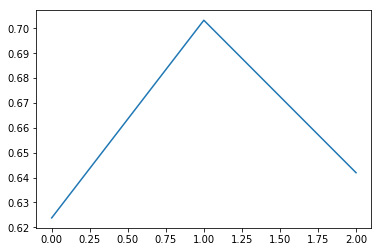

In [122]:
file = [['я','ненавидеть'],['совершить','самоубийство'], ['отчуждение'], ['пирожок','очень','вкусный'], ['смерть','искусство']]
file_sim = tangentiality_array_1(file)
plt.plot(range(len(file_sim)),file_sim)

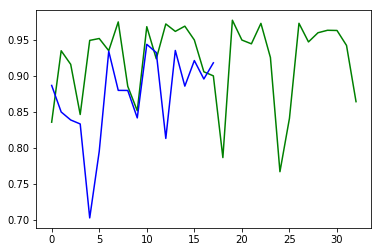

In [126]:
files = [sample['control']['HP-03'], sample['schizo']['SP-03']]
file_sim_1 = tangentiality_array_1(files[0])
file_sim_2 = tangentiality_array_1(files[1])
plt.plot(range(len(file_sim_1)),file_sim_1, 'g')
plt.plot(range(len(file_sim_2)),file_sim_2, 'b')

In [109]:
def random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

#2A9FB5


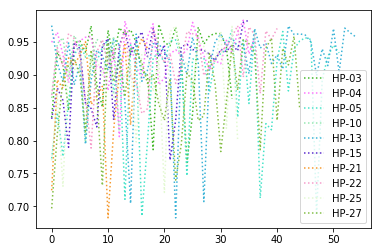

In [138]:
for filename in sample['control']:
    file = sample['control'][filename]
    file_sim = tangentiality_array_1(file)
    plt.plot(range(len(file_sim)), file_sim, random_color(), label=filename, linestyle=':')
plt.legend()

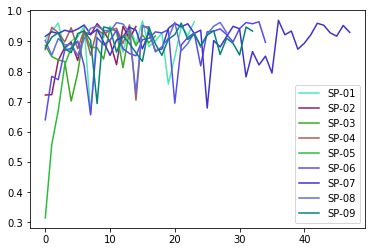

In [139]:
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    file_sim = tangentiality_array_1(file)
    plt.plot(range(len(file_sim)),file_sim, random_color(), label=filename, linestyle='-')
plt.legend()

<h3>Local coherence</h3>
    (let i = cosine distance between an averaged vector of the neighbouring clauses)
<ul>
    <li>average i, range of i, SD of i for each participant</li>
    <li>the differences between the averages for the groups</li>
    <li>the differences between the averages for the averages of the groups</li>
    <li>a graph: <br>
        x axis: number of the current clause <br>
        y axis: i</li>
</ul>

<h3>Global coherence</h3>
    (let us take a centroid of each clause, then a centroid of these centroids in one text, then a centroid of the centroids of all the texts at hand)
<ul>
    <li>cosine distance between the centroid of all the texsts and the centroid of the current text for each partcipant</li>
    <li>cosine distance between the centroid of all the <i>control</i> texsts and the centroid of the current text for each partcipant</li>
</ul>

<h3>Violations of completeness</h3> 

(see levenshtein, needleman, wunsch [wiki: Levenshtein_distance](https://en.wikipedia.org/wiki/Levenshtein_distance) and [wiki: Needleman–Wunsch_algorithm](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm))<br>
    (let the set of topics be defined as text (set_of_propositions.txt))
<ul>
    <li>cosine distance between the centroid of the topics and the centroid of the text</li>
    <li>cosine distance between each topic and each clause and alignment levenshtein, needleman, wunsch (pay attention to the weight of the alignment)</li>
</ul>